# PID Tuning

Let's work out Example 7.7 under the assumption that we don't actually have a model for the system. This code will simulate some system that we can measure the response for, but that is the only information we have about it.

We'll first need to code the system using the block diagram in Figure 7.25.

As always with python, we start by importing all of the packages we'll need.

In [1]:
import numpy as np
import control
import matplotlib.pyplot as plt # plotting library
from sympy import symbols
from sympy.physics.control.lti import TransferFunction, Feedback, Series
from sympy.physics.control.control_plots import pole_zero_plot, step_response_plot, step_response_numerical_data

Let's use sympy to perform symbolic algebra on our block diagram to make sure we didn't make a mistake

In [2]:
# define all of the symbols we're going to use
Kp, KI, KD, b, zeta, wn, s = symbols('K_p K_I K_D b zeta omega_n s')

# We'll get the closed-loop TF of Y/R first

# Define the TF of the Process (Gp in the notes)
num_Gp = 1
den_Gp = s*(s+b)*(s+2*zeta*wn)
Gp = TransferFunction(num_Gp,den_Gp,s)

# Define the TF of the Controller (Gc in the notes)
num_Gc = KD*s**2 + Kp*s + KI
den_Gc = s
Gc = TransferFunction(num_Gc,den_Gc,s)

# Get closed-loop TF Y/R when Td=0
TF_R_OL = Series(Gc,Gp).doit() # Open-loop TF
TF_R = Feedback(TF_R_OL, sign=-1).doit()

TF_R.simplify().expand()

TransferFunction(K_D*s**2 + K_I + K_p*s, K_D*s**2 + K_I + K_p*s + 2*b*omega_n*s**2*zeta + b*s**3 + 2*omega_n*s**3*zeta + s**4, s)

In [3]:
# Now get the closed-loop TF of Y/Td when R=0

TF_Td = Feedback(Gp,Gc,sign=-1).doit()

TF_Td.simplify().expand()

TransferFunction(s, K_D*s**2 + K_I + K_p*s + 2*b*omega_n*s**2*zeta + b*s**3 + 2*omega_n*s**3*zeta + s**4, s)

## Manual Model-free Tuning
Now we can act like we don't know anything about the system and instead observe the response as we change the gains.

The first step is to set Kd and KI to zero and increase Kp until the system is nearly unstable. We'll do this with the $\frac{Y(s)}{R(s)}$ TF. 

Let's start with $K_p=100$.

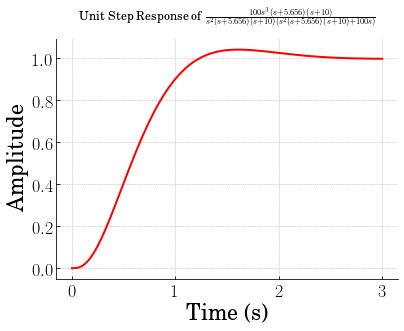

In [6]:
# sub in values for the variables
TF = TF_R.subs([
              (b,10),
              (zeta,0.707),
              (wn,4),
              (KI,0),
              (KD,0),
              (Kp,100)]) # We'll start with Kp=100

step_response_plot(TF,upper_limit=3,grid=False,color='r')

This is definitely not nearly unstable. Let's try $K_p=1000$.

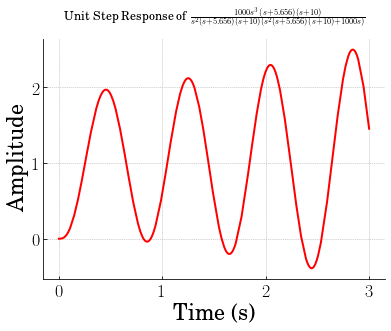

In [7]:
# sub in values for the variables
TF = TF_R.subs([
              (b,10),
              (zeta,0.707),
              (wn,4),
              (KI,0),
              (KD,0),
              (Kp,1000)])

step_response_plot(TF,upper_limit=3,grid=False,color='r')

This is unstable, which means $K_p$ is too high.

Let's do $K_p=885.5$. (This is from the book. I didn't just eye-ball it.)

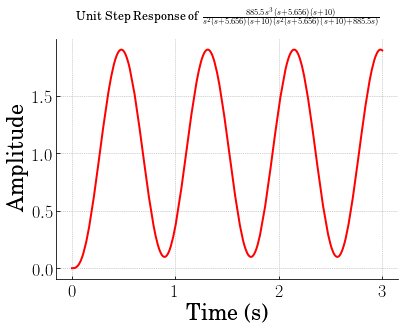

In [8]:
# sub in values for the variables
TF = TF_R.subs([
              (b,10),
              (zeta,0.707),
              (wn,4),
              (KI,0),
              (KD,0),
              (Kp,885.5)])

step_response_plot(TF,upper_limit=3,grid=False,color='r')

That seems about right.

The next step is to reduce $K_p$ until the amplitude of the second peak is $\frac{1}{4}$ of the first peak. The book suggests starting by making $K_p$ half, so $K_p=\frac{885.5}{2}=442.75$. Continue modifying $K_p$ until the desired value is reached. In this case, $K_p=370$.

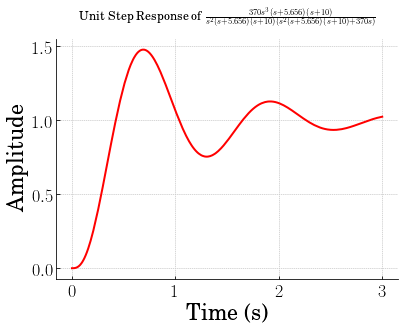

In [9]:
# sub in values for the variables
TF = TF_R.subs([
              (b,10),
              (zeta,0.707),
              (wn,4),
              (KI,0),
              (KD,0),
              (Kp,370)])

step_response_plot(TF,upper_limit=3,grid=False,color='r')

That seems like a nice response. What can we do to improve it?

We can add derivative gain, $K_D$. Remember that $K_D$ will act like a damper to reduce our settling time and overshoot. Let's use $K_D=60$.

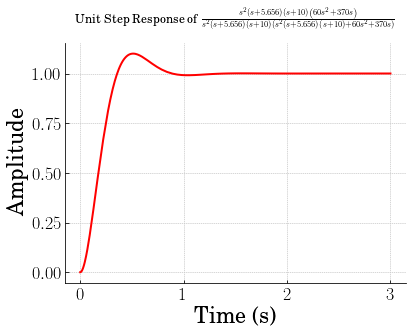

In [10]:
# sub in values for the variables
TF = TF_R.subs([
              (b,10),
              (zeta,0.707),
              (wn,4),
              (KI,0),
              (KD,60),
              (Kp,370)])

step_response_plot(TF,upper_limit=3,grid=False,color='r')

This is a pretty good response. Theoretically, we don't have to add integral gain, $K_I$, because we don't have any steady state error. But in reality, we'll almost always have some steady-state error. Sometimes its negligible, sometimes not. Let's add $K_I=100$ and see what happens.

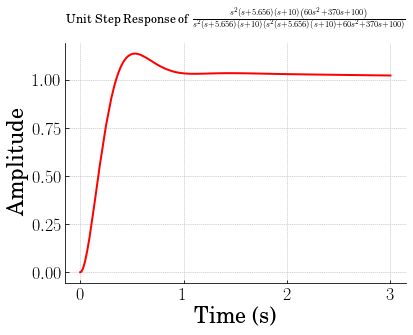

In [11]:
# sub in values for the variables
TF = TF_R.subs([
              (b,10),
              (zeta,0.707),
              (wn,4),
              (KI,100),
              (KD,60),
              (Kp,370)])

step_response_plot(TF,upper_limit=3,grid=False,color='r')

Looks like in this case $K_I$ has added a noticable increase in settling time. That is the trade-off for having a mechinism that will mitigate our steady-state error.

## Ziegler-Nichols Tuning

Let's compare manual tuning to the closed-loop Ziegler-Nichols method. We already know that the ultimate gain is $K_U=885.5$. The ultimate period was also $P_U=0.83$ seconds. From there we use the table to assign the gains as:

$K_p=0.6K_U$

$K_I=\frac{1.2K_U}{P_U}$

$K_D=\frac{0.6K_U P_U}{8}$

The step response with these gains looks like this.

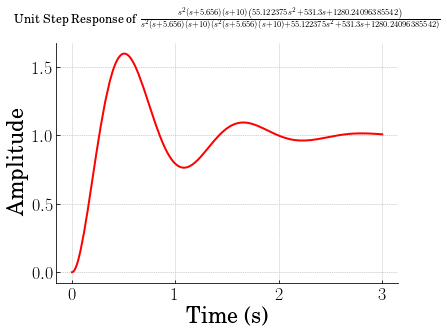

In [12]:
KU=885.5 # ultimate gain
PU=0.83 # ultimate period

prop_gain = 0.6*KU
int_gain = 1.2*KU/PU
deriv_gain = 0.6*KU*PU/8

# sub in values for the variables
TF = TF_R.subs([
              (b,10),
              (zeta,0.707),
              (wn,4),
              (KI,int_gain),
              (KD,deriv_gain),
              (Kp,prop_gain)])

step_response_plot(TF,upper_limit=3,grid=False,color='r')

The gains from using Ziegler-Nichols cause the system to have much more overshoot than with manual tuning. So why not always use manual tuning? First, Ziegler-Nichols allowed us to tune the gains faster with less trial and error. Second, Ziegler-Nichols was designed to give systems decent disturbance rejection.

If we apply a step input in disturbance when $R(s)=0$:

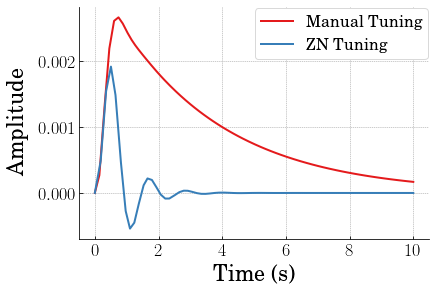

In [13]:
# sub in values for manual tuning
TF_Td_manual = TF_Td.subs([
              (b,10),
              (zeta,0.707),
              (wn,4),
              (KI,100),
              (KD,60),
              (Kp,370)])

# sub in values for Ziegler-Nichols tuning
TF_Td_ZN = TF_Td.subs([
              (b,10),
              (zeta,0.707),
              (wn,4),
              (KI,int_gain),
              (KD,deriv_gain),
              (Kp,prop_gain)])

manual_response = step_response_numerical_data(TF_Td_manual,upper_limit=10,grid=False,color='r')
ZN_response = step_response_numerical_data(TF_Td_ZN,upper_limit=10,grid=False,color='r')


# plot the two responses
#############################################################
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units font
plt.setp(ax.get_ymajorticklabels(),fontsize=18)
plt.setp(ax.get_xmajorticklabels(),fontsize=18)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Amplitude', fontsize=22, weight='bold', labelpad=10)

plt.plot(manual_response[0], manual_response[1], linewidth=2, linestyle='-', label=r'Manual Tuning')
plt.plot(ZN_response[0], ZN_response[1], linewidth=2, linestyle='-', label=r'ZN Tuning')
# uncomment below and set limits if needed
# plt.xlim(0,5)
# plt.ylim(-0.01,2.5)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 1, fancybox=True, )
ltext  = leg.get_texts()
plt.setp(ltext,fontsize=16)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# save the figure as a high-res pdf in the current folder
# plt.savefig('plot_filename.pdf')

# plt.show()